In [1]:
from PIL import Image, ImageFilter
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
import torch.nn.functional as F
from scipy import ndimage
from skimage.measure import regionprops

In [2]:
!curl ident.me

147.32.71.9

### Loss viz

In [4]:
def moving_average(a, n=8) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def visualize_logs(path):
    lg = np.load(path, allow_pickle=True)
    plt.figure(figsize=(20,10))
    runs = { metric_name: [] for metric_name, _ in lg[0].items() }
    for k,v in enumerate(lg):
        for metric_name, metric_value in v.items():
            runs[metric_name] = runs[metric_name] + metric_value
    for k,v in runs.items():
        v = moving_average(v)
        plt.plot(v, label=k)
    plt.legend()


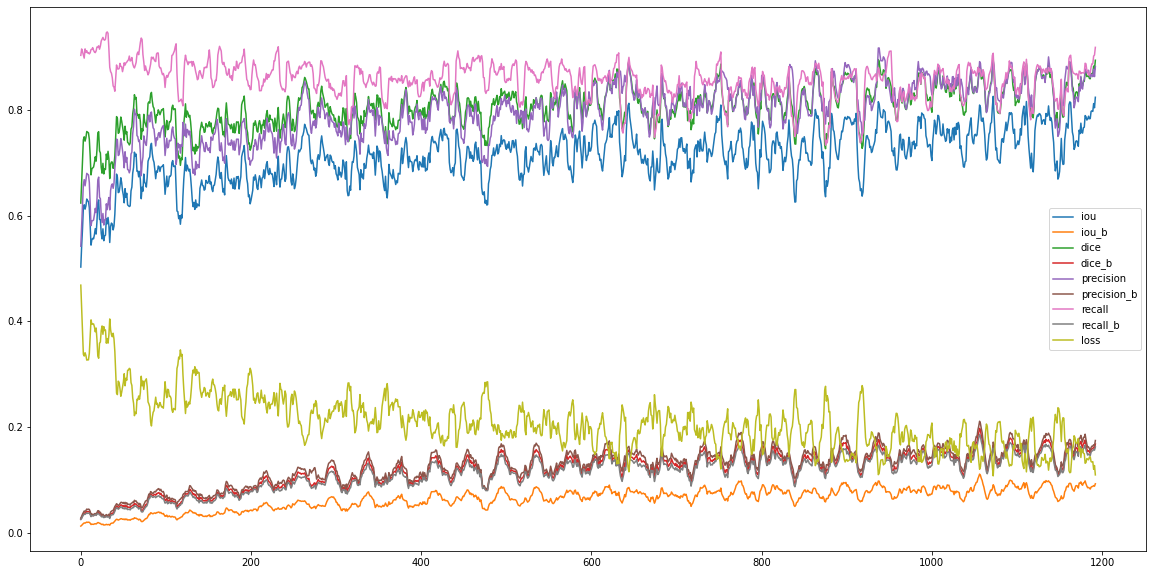

In [20]:
visualize_logs('/home/kafkaon1/FVAPP/out/run_230503-140231/logs/val_logs.npy')

In [54]:
img = Image.open('/home/kafkaon1/Dev/FVAPP/data/CZ4/fac_imgs/20230716_135813.jpg')
label = Image.open('/home/kafkaon1/Dev/FVAPP/data/CZ4/fac_labels/20230716_135813.jpg')
imga = np.array(img)
la = np.array(label).astype(float)
I = T.ToTensor()(img).unsqueeze(0)
l = T.ToTensor()(label).unsqueeze(0)

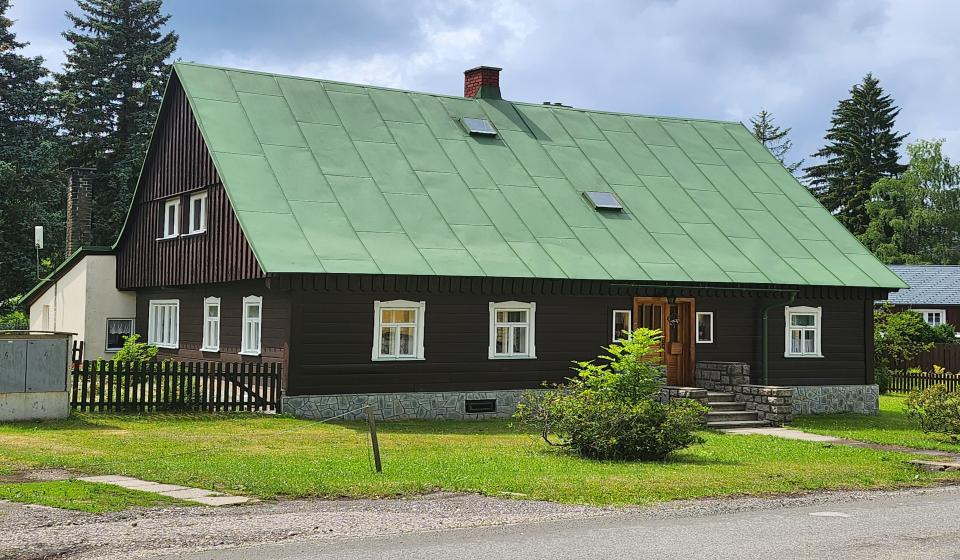

In [56]:
img

In [45]:
I.shape

torch.Size([1, 3, 560, 960])

### Loss development

The paper LF

In [43]:
# boundary map
gt_b = F.max_pool2d(
            1 - l, kernel_size=3, stride=1, padding=(3 - 1) // 2)
gt_b -= 1 - l

# extended boundary map
ks = 5
gt_b_ext = F.max_pool2d(
    gt_b, kernel_size=ks, stride=1, padding=(ks - 1) // 2)


In [44]:
im = T.ToPILImage()(gt_b[0,0,:,:])
im_ext = T.ToPILImage()(gt_b_ext[0,0,:,:])

In [48]:
plt.imsave('/home/kafkaon1/FVAPP/graphics/border_ext.png', gt_b_ext[0,0,:,:])

My LF

In [2]:
t = l[:,:,350:500,50:200]

NameError: name 'l' is not defined

In [31]:
gb = T.GaussianBlur(9)

In [35]:
# i need to pad the t tensor with zeros before conv2d

#t_p = F.pad(t, (5, 5, 5, 5), mode='constant', value=0)  # pad with ones

gt_d = gb(t)
#gt_d = F.conv2d(
 #           1-t_p, torch.ones([1,1,11,11]).double(), stride=1)

gt_d *= 1-t

In [36]:
im = T.ToPILImage()(gt_d[0,0,:,:])

In [37]:
h = np.array(im.histogram()) 

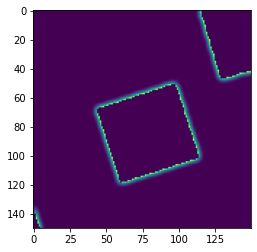

In [38]:
plt.imshow(np.array(im))

My LF2

In [41]:
# boundary map
gt_b = F.max_pool2d(
            1 - l, kernel_size=3, stride=1, padding=(3 - 1) // 2)
gt_b -= 1 - l


In [42]:
gb = T.GaussianBlur(9)

In [20]:
gt_bb = gb(gt_b)

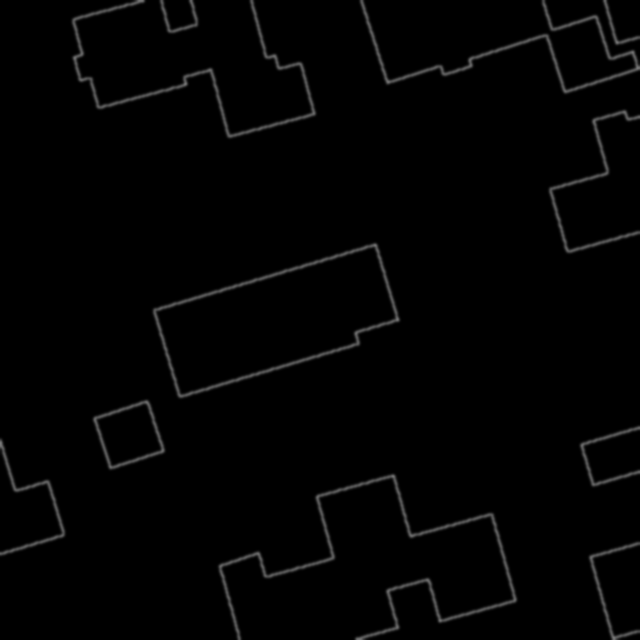

In [21]:
T.ToPILImage()(gt_bb[0,0,:,:])

In [33]:
loss = torch.nn.BCELoss(reduction='none')


intermediate_losses = loss((1-l).float(), l.float())


### Model results

In [4]:
model1 = torch.load('/home/kafkaon1/Dev/FVAPP/out/train/run_230522-093052/checkpoints/Deeplabv3_err:0.23119_ep:29.pth', map_location=torch.device('cpu'))
torch.no_grad()
model1.eval()
print(".")

/home/kafkaon1/miniconda3/envs/ml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


.


In [8]:
out = model1(I)

AttributeError: 'UpsamplingBilinear2d' object has no attribute 'recompute_scale_factor'

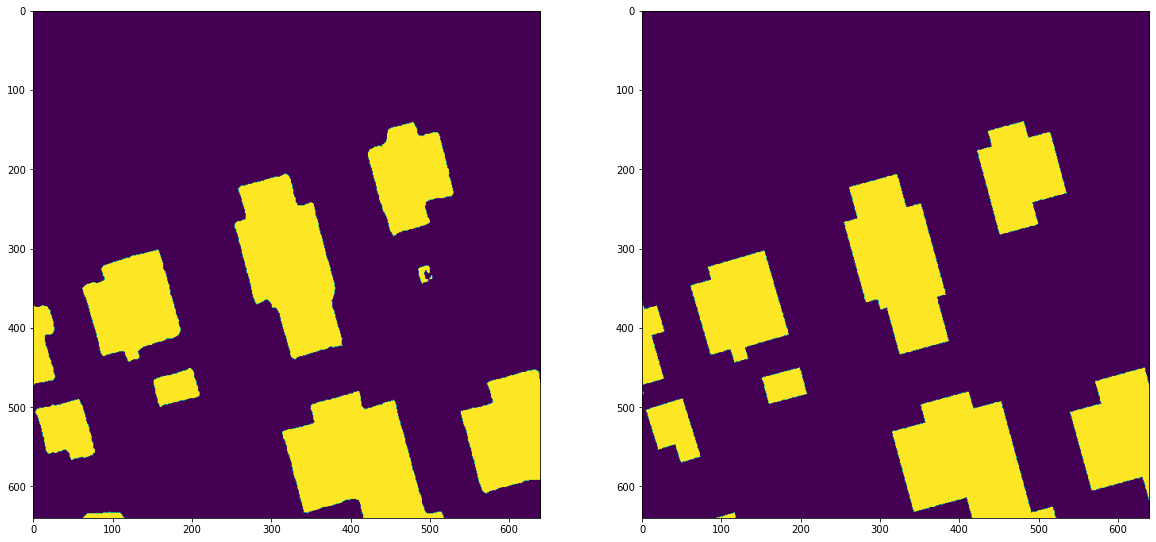

In [44]:
fig, ax = plt.subplots(1,2 ,figsize=(20,10))
ax[0].imshow((out[0,0]>0.5).detach().numpy())
ax[1].imshow(la)

In [29]:
plt.imsave('/home/kafkaon1/FVAPP/graphics/segBLE.png', (out[0,0]>0.5).detach().numpy())

### Regularization and polygon fitting

#### Regularization from paper

In [47]:
from models import DLV3Reg, extractPolygons

In [51]:
#model = DLV3Reg('/home/kafkaon1/FVAPP/out/train/run_230522-093052/checkpoints/Deeplabv3_err:0.23119_ep:29.pth', device='cuda:0', do_reg=False, do_poly=True)
model = DLV3Reg('/home/kafkaon1/Dev/FVAPP/out/train/run_230808-155251/checkpoints/Deeplabv3_err:0.19785_ep:134.pth', device='cuda:0', do_reg=True, do_poly=True)
model.to('cuda:0')
model.eval()
print('.')

.


In [57]:
outta = model.predict(I.to('cuda:0'))

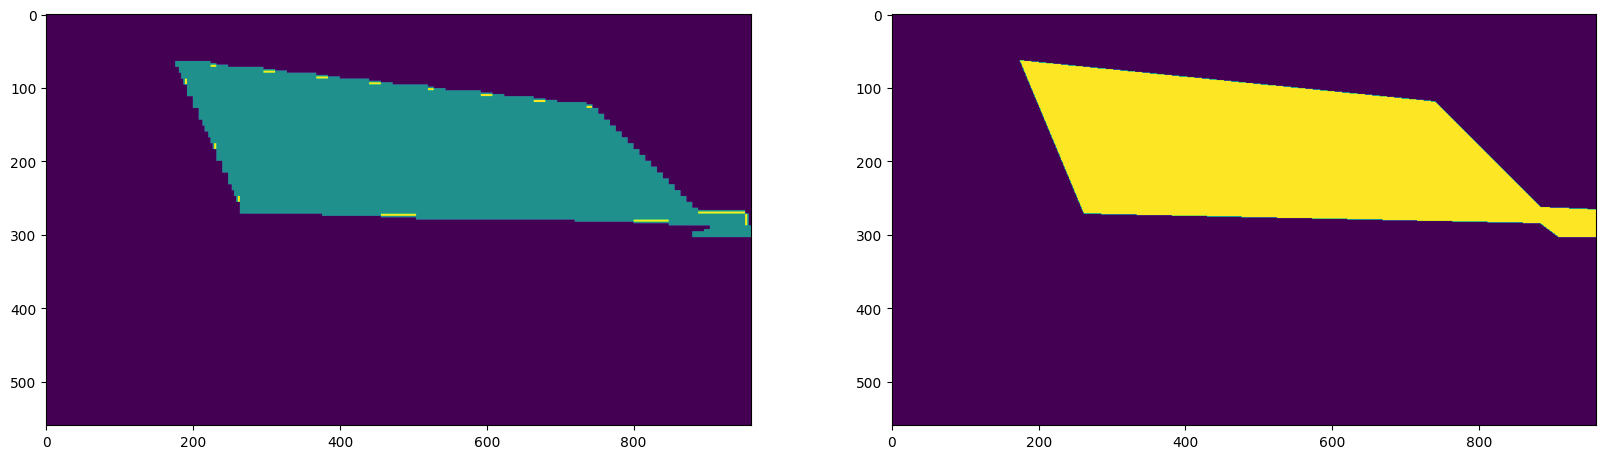

In [58]:
fig, ax = plt.subplots(1,2 ,figsize=(20,10))
ax[0].imshow(la)
ax[1].imshow(outta[0,0, :, :].detach().cpu().numpy())

In [38]:
plt.imsave('/home/kafkaon1/FVAPP/graphics/regBMP.png', outta[0,0,:,:].detach().cpu().numpy())

In [ ]:
mcrnn = torch.load('/home/kafkaon1/Dev/FVAPP/out/train/run_230906-171249/checkpoints/MaskRCNN_ep:150.pth')

#### Polygon fitting

Hough transform

In [ ]:
image_out = T.ToPILImage()(((out[0,0]>0.5)).float())

In [18]:
lab = image_out.filter(ImageFilter.FIND_EDGES)

In [20]:
minLineLength = 100
maxLineGap = 30

In [21]:
lb = np.array(lab)

In [22]:
lines = cv2.HoughLinesP(lb,1,np.pi/180,30,minLineLength,maxLineGap)

In [23]:
cdst = cv2.cvtColor(lb, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

In [24]:
for i in range(0, len(lines)):
    l = lines[i][0]
    cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

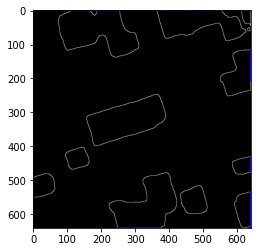

In [25]:
plt.imshow(cdstP)

PolyfitDP

In [35]:
imagoa = np.array(image_out)
cdst = cv2.cvtColor(imagoa, cv2.COLOR_GRAY2BGR)
cdstP = np.copy(cdst)

In [71]:
output_filtered = np.copy(np.array(image_out))
positive_label_areas = np.zeros((output_filtered.shape[0], output_filtered.shape[1]), dtype=np.uint8)
positive_label_areas[np.where(output_filtered == 255)] = 1

# Generate a label mask that assigns a unique label to each positive area
label_mask, num_labels = ndimage.label(positive_label_areas)

label = label_mask[320, 320]

output_filtered[np.where(label_mask != label)] = 0

# labeled_arr, num_labels = ndimage.label(arr)

# get bounding boxes of connected components
regions = regionprops(label_mask)
bbx = regions[label].bbox

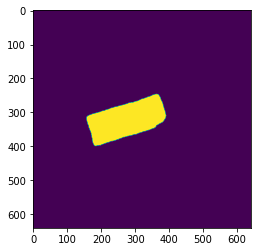

In [72]:
plt.imshow(output_filtered)

In [61]:

contours, _ = cv2.findContours(output_filtered, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = contours[0]
epsilon = 0.005*cv2.arcLength(cnt,True)

In [62]:
approx = cv2.approxPolyDP(cnt,epsilon,True)

In [63]:
cdsat = cv2.cvtColor(output_filtered, cv2.COLOR_GRAY2BGR)
cdstPa = np.copy(cdsat)

In [64]:
# cv2.drawContours(cdstP, [cnt], -1, (0,255,255), 3)
cv2.drawContours(cdstPa, [approx], -1, (0,0,255), 3)
print(".")

.


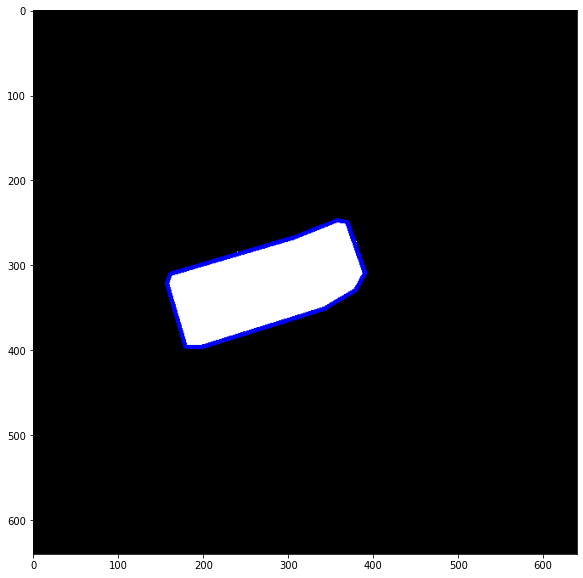

In [65]:
plt.figure(figsize=(10,10))
plt.imshow(cdstPa)

Implementation of PolyCNN

In [20]:
from models import PolyWorld

In [21]:
model = PolyWorld()

Loading pretrained model


In [28]:
p = model.predict(I.cuda())

In [31]:
p

[[[0.0, 492.1875, 576.5625, 298.125, 568.125, 508.125, 0.0, 492.1875],
  [502.5, 0.0, 26.25, 97.5, 0.0, 144.375, 502.5, 0.0],
  [540.9375,
   0.0,
   703.125,
   381.5625,
   852.1875,
   514.6875,
   538.125,
   510.9375,
   540.9375,
   15.0,
   540.9375,
   0.0],
  [789.375, 392.8125, 0.0, 202.5, 704.0625, 310.3125, 789.375, 392.8125],
  [745.3125,
   505.3125,
   779.0625,
   452.8125,
   832.5,
   485.625,
   835.3125,
   493.125,
   745.3125,
   505.3125]]]

[0.0, 492.1875, 576.5625, 298.125, 568.125, 508.125, 0.0, 492.1875]
[502.5, 0.0, 26.25, 97.5, 0.0, 144.375, 502.5, 0.0]
[540.9375, 0.0, 703.125, 381.5625, 852.1875, 514.6875, 538.125, 510.9375, 540.9375, 15.0, 540.9375, 0.0]
[789.375, 392.8125, 0.0, 202.5, 704.0625, 310.3125, 789.375, 392.8125]
[745.3125, 505.3125, 779.0625, 452.8125, 832.5, 485.625, 835.3125, 493.125, 745.3125, 505.3125]


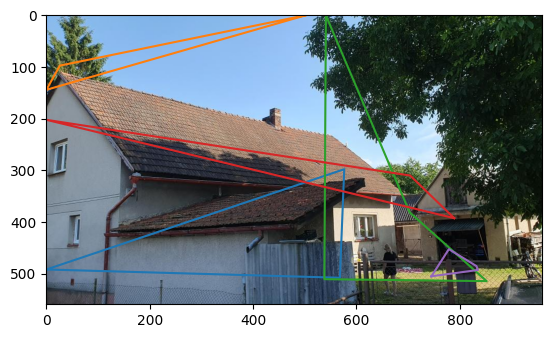

In [37]:
plt.imshow(imga)
for poly in p[0]:
    print(poly)
    # print(poly[::2],poly[1::2])
    plt.plot(poly[::2],poly[1::2])



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (1, 5) + inhomogeneous part.

In [25]:
p.reshape(p.shape[0], p.shape[1]//2, 2).shape

AttributeError: 'list' object has no attribute 'reshape'

In [23]:
p

[[[0.0, 492.1875, 576.5625, 298.125, 568.125, 508.125, 0.0, 492.1875],
  [502.5, 0.0, 26.25, 97.5, 0.0, 144.375, 502.5, 0.0],
  [540.9375,
   0.0,
   703.125,
   381.5625,
   852.1875,
   514.6875,
   538.125,
   510.9375,
   540.9375,
   15.0,
   540.9375,
   0.0],
  [789.375, 392.8125, 0.0, 202.5, 704.0625, 310.3125, 789.375, 392.8125],
  [745.3125,
   505.3125,
   779.0625,
   452.8125,
   832.5,
   485.625,
   835.3125,
   493.125,
   745.3125,
   505.3125]]]

Implementation of SAM

In [7]:
sys.path.append("./third_party/segment-anything/")
from segment_anything import sam_model_registry, SamPredictor

In [8]:
sam_checkpoint = "/home/kafkaon1/FVAPP/third_party/segment-anything/wghs.pth"
model_type = "vit_h"

device = "cuda:1"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [7]:
image = np.array(Image.open(img_path))

In [9]:
predictor.set_image(image)

In [ ]:
input_boxes = torch.tensor([[120, 230, 402, 420], [200, 450, 550, 639]], device=predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, image.shape[:2])
input_box = [120, 230, 402, 420]

In [18]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


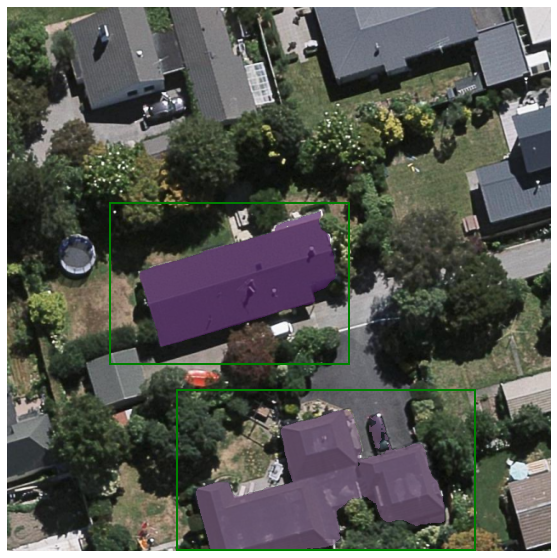

In [22]:
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [25]:
masks.sum(axis=(0)).shape

torch.Size([1, 640, 640])

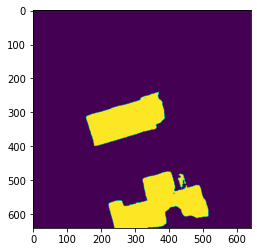

In [27]:
plt.imshow(masks.sum(axis=(0))[0].detach().cpu().numpy())

In [21]:
mask.shape

torch.Size([1, 640, 640])

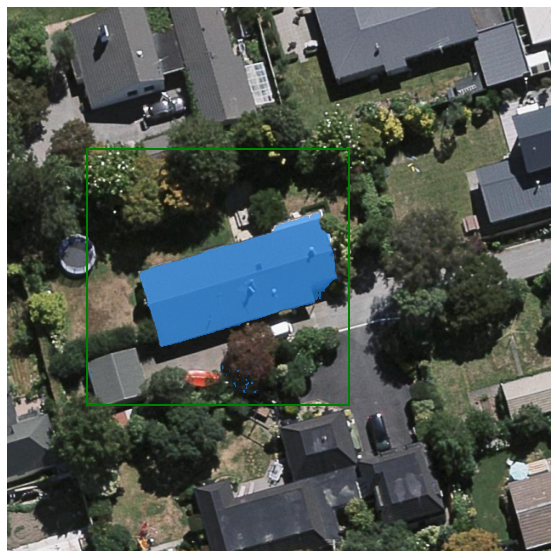

In [13]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [2]:
import torchvision.models.detection as det
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
# We will get mask-rcnn model for this video
model = det.maskrcnn_resnet50_fpn(pretrained=True) #maskrcnn_resnet50_fpn_v2(pretrained=True)
model.eval()

/home/kafkaon1/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kafkaon1/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [1]:
from datasetI import FVDatasetIS
from torch.utils.data import DataLoader

train_dataset = FVDatasetIS(
    '/home/kafkaon1/Dev/FVAPP/data/CZ7/fac_imgs', '/home/kafkaon1/Dev/FVAPP/data/CZ7/fac_labels', 
    names_path='/home/kafkaon1/Dev/FVAPP/data/CZ7/train_fac.txt',
    augmentation=True,
)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=10, persistent_workers=True)

In [4]:
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [10]:
model(train_dataset[0][0].unsqueeze(0), train_dataset[0])

AttributeError: 'Tensor' object has no attribute 'items'

In [8]:
train_dataset[0][0].shape 

torch.Size([3, 560, 960])